# QuantumBlack Hackathon - AI For Good

Binary classifier that predicts presence of methane emissions in an image. Model integrated in a Streamlit Web App for seamless workflows.

***
by: Clara Besnard, Ian Moon, Marina Pellet, Łukasz Pszenny, Adel Remadi, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers building the binary classifier to predict the presence of a methane plume in a given image.

In [ ]:
# if necessary, run installs
%pip install os pandas geopandas shapely reverse_geocoder pycountry

### 1. Import Packages

In [60]:
from importlib import reload
reload(prepData)
reload(loadData)
reload(modeling)
reload(vizData)

<module 'util.visualize_data' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T3_QuantumBlack AI For Good\\QB-AI-for-Good\\util\\visualize_data.py'>

In [1]:
# import own scripts
import util.preprocess_data as prepData
import util.load_data as loadData
import util.modeling as modeling
import util.visualize_data as vizData

In [2]:
# data handling
import os
import numpy as np
from PIL import Image

# data viz
import matplotlib.pyplot as plt

# modeling
import torch

# hyperparam optimization
from ray import tune

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data

In [4]:
# get transforms
trn_transform, valtst_transform = prepData.get_transform() # to be applied during training
trn_transform_viz, valtst_transform_viz = prepData.get_transform(visualize = True) # to visualize what transform does (without normalization)

In [5]:
# fetch metadata
trnval_metadata = loadData.load_metadata("images/metadata.csv", set = "train")
tst_metadata    = loadData.load_metadata("images/metadata.csv", set = "test")

# perform train validation split
trn_metadata, val_metadata = loadData.trainval_split(trnval_metadata, val_size = 0.2)

# show sizes of datasets
print(f"Size of trainval data: {trnval_metadata.__len__()}")
print(f"Size of training data: {trn_metadata.__len__()}")
print(f"Size of validation data: {val_metadata.__len__()}")
print(f"Size of test data: {tst_metadata.__len__()}")

Size of trainval data: 430
Size of training data: 344
Size of validation data: 86
Size of test data: 0


In [6]:
# get pytorch datasets for visualization
trn_dataset_viz_no_transform = loadData.CustomDataset(trn_metadata, apply_CLAHE = False)
trn_dataset_viz_transform    = loadData.CustomDataset(trn_metadata, transform = trn_transform_viz, resize = True, apply_CLAHE = True)

# get pytorch datasets for modeling
trn_dataset = loadData.CustomDataset(trn_metadata, transform = trn_transform, resize = True, apply_CLAHE = True)
val_dataset = loadData.CustomDataset(val_metadata, transform = valtst_transform, resize = True, apply_CLAHE = True)
tst_dataset = loadData.CustomDataset(tst_metadata, transform = valtst_transform, resize = True, apply_CLAHE = True)

In [7]:
# get mean and std of dataset to identify values by which we need to normalize
trn_dataset.compute_mean_std()

(60.0644191863925, 58.84460681054689)

images/no_plume/20230305_methane_mixing_ratio_id_2384.tif
images/no_plume/20230305_methane_mixing_ratio_id_2384.tif
4096
50176


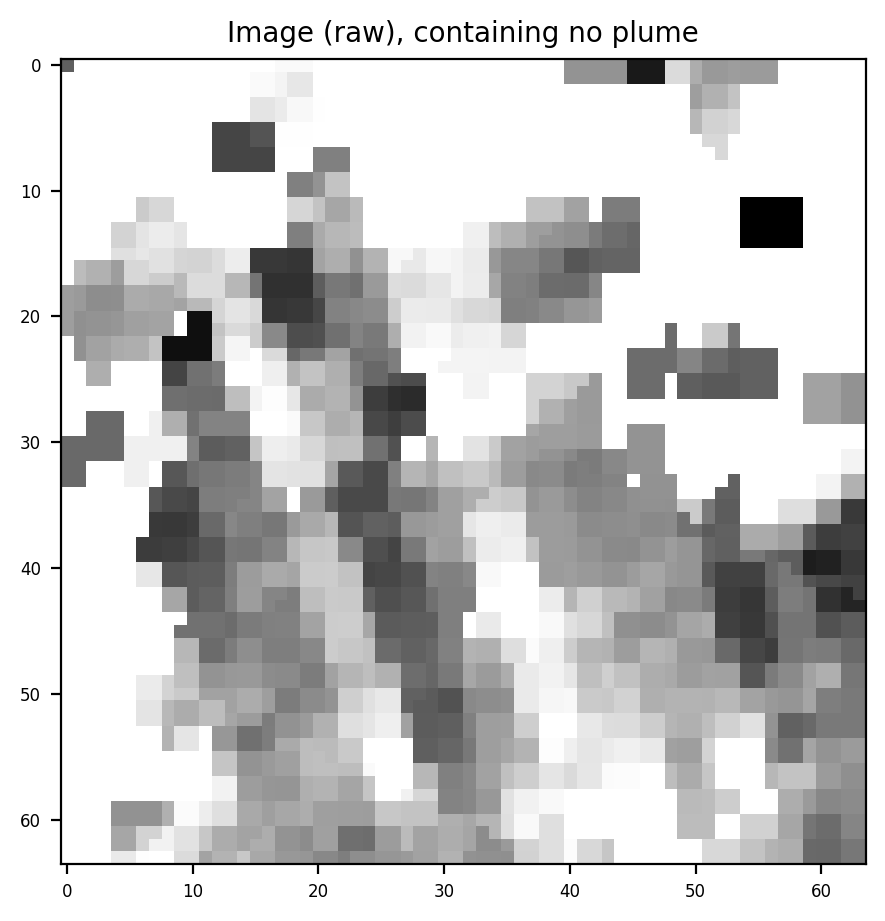

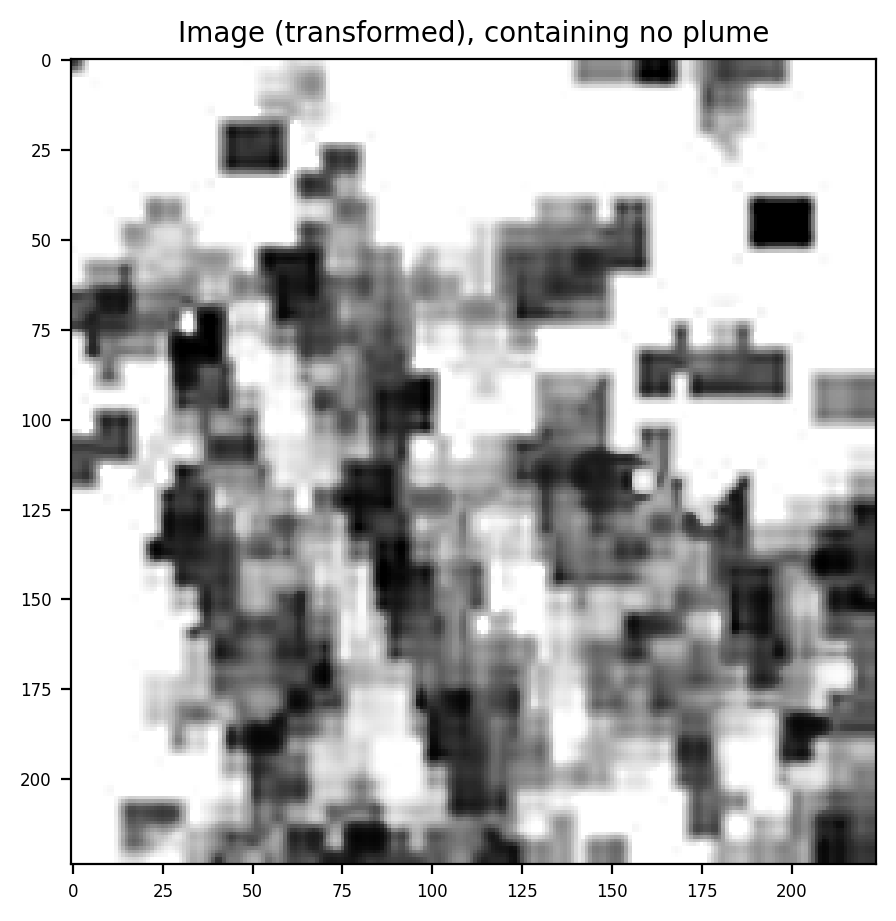

In [10]:
# fetch random image & mask for visualization (training)
idx = 5

# get non-transformed image
_, img, lbl = trn_dataset_viz_no_transform.__getitem__(idx)
path = trn_metadata.loc[idx].path
print(path)

# get transformed image
_, img_tf, _ = trn_dataset_viz_transform.__getitem__(idx)
path = trn_metadata.loc[idx].path
print(path)

# visualize original image (without transformations)
vizData.visualize(img, lbl = lbl)

# visualize transformed image
vizData.visualize(img_tf, lbl = lbl, transform = True)

In [70]:
def stratified_split(df, k, test = None):
    if test is not None:
        df, test = 
    
    unique_id_coords = df['id_coord'].unique()
    np.random.shuffle(unique_id_coords)  # shuffle the unique IDs

    folds = {}
    size_per_fold = int(len(df) / k)

    for i in range(k):
        train_id_coords = []
        val_id_coords = []

        val_count = 0

        for id_coord in unique_id_coords:
            id_coord_df = df[df['id_coord'] == id_coord]
            # add to validation set if it does not exceed the size per fold or 
            # it is the last iteration and there is space left in the validation set
            if (val_count + len(id_coord_df) <= size_per_fold) or (i == k - 1 and val_count < size_per_fold):
                val_id_coords.append(id_coord)
                val_count += len(id_coord_df)
            else:
                train_id_coords.append(id_coord)

        # create train and validation dataframes based on the split
        train_df = df[df['id_coord'].isin(train_id_coords)]
        val_df = df[df['id_coord'].isin(val_id_coords)]

        # add the train and validation dataframes to the folds dictionary
        folds[i] = {'train': train_df, 'val': val_df}

        # update df and unique_id_coords for the next iteration
        df = df[~df['id_coord'].isin(val_id_coords)]
        unique_id_coords = [id_coord for id_coord in unique_id_coords if id_coord not in val_id_coords]

    return folds, unique_id_coords

In [102]:
folds, test_df, leftover_coords = stratified_split(trnval_metadata, 3, 0.2)

### 3. Modeling

Learnings:
- for Resnet18 and 34, pre-trained models do not seem to work well (maybe because we needed to change first convolution because input images have only one channel and not three -- so we lost all pre-trained weights for first convolution)
- Resnet18 same performance level as ResNet34, maybe even slightly better --> no need to use ResNet34 then (overly complex)
- batch size of 16 better than 8 and 4 for ResNets --> maybe try out even bigger batches
- higher number of epoch better (50 worked well, 20 ok, 10 too low)

In [9]:
# where to save trial results to
ray_path = os.path.normpath(os.getcwd()).replace("\\", "/") +"/ray_results/"
if not os.path.isdir(ray_path):
    os.mkdir(ray_path)

# ignore warnings that show in every raytune run
import warnings
warnings.simplefilter(action = "ignore", category = np.VisibleDeprecationWarning)

In [11]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # basic infos
    "max_epochs": 50,
    "batch_size": tune.grid_search([8, 16, 32]),
    "dir": os.path.normpath(os.getcwd()).replace("\\", "/"),
    "verbose": False,
    "save": True,
    
    # preprocessing
    "resize": True, # resize images from (64, 64) to (224, 224)
    "apply_CLAHE": tune.grid_search([False, True]), # improve image contrast
    
    # model
    "model": tune.grid_search(["ResNet18", "ResNet34"]),
    "pretrained": tune.grid_search([False, True]),
    
    # scheduler
    "lr_s": "Cosine", # StepLR decreases learning rate every 10 epochs by factor of 10
    
    # optimizer
    "lr":   1e-2,
    "wd":   1e-2,
    "mom":  0.9,
    
    # loss function
    "criterion": "BCE"
}

In [12]:
# how many trials to run (if grid_search utilized, it will run this number per grid_search value)
num_samples = 1

# run experiment
result_grid = modeling.run_ray_experiment(
    modeling.ray_trainable, config, ray_path, num_samples,
    metric_columns = ["trn_auc", "val_auc", "training_iteration"],
    parameter_columns = ["batch_size", "apply_CLAHE", "model", "pretrained"]
)

2023-05-13 20:03:12,776	INFO worker.py:1553 -- Started a local Ray instance.
2023-05-13 21:28:23,701	INFO tune.py:798 -- Total run time: 5109.60 seconds (5109.56 seconds for the tuning loop).


**Analyze RayTune experiment.**

In [13]:
restored_tuner, result_grid = modeling.open_validate_ray_experiment("ray_results/1_grid_ResNet18-34", modeling.ray_trainable)

2023-05-13 21:55:50,715	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
2023-05-13 21:55:50,718	INFO experiment_analysis.py:789 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


Loading results from ray_results/1_grid_ResNet18-34...
Done!

No errors! Number of terminated trials: 24


In [16]:
# get best N trials in this experiment (highest validation accuracy [averaged across 4 folds])
N = 20
best_result_df = result_grid.get_dataframe(
    filter_metric="val_auc", filter_mode="max"
)
best_result_df = best_result_df[["trial_id", "training_iteration", "config/batch_size",
                                 "config/model", "config/pretrained",
                                 "config/apply_CLAHE", # "config/resize"
                                 "config/lr", # "config/lr_s", "config/wd", "config/mom", 
                                 "trn_loss", "val_loss", "trn_auc", "val_auc"]]

best_result_df = best_result_df.sort_values(by=["val_auc"], ascending = False)

if len(result_grid) > N:
    best_result_df = best_result_df.head(N)

best_result_df

,trial_id,training_iteration,config/batch_size,config/model,config/pretrained,config/apply_CLAHE,config/lr,trn_loss,val_loss,trn_auc,val_auc
8,6e0db_00008,48,16,ResNet34,False,False,0.01,0.266935,0.183575,0.961520,0.983193
0,6e0db_00000,50,8,ResNet18,False,False,0.01,0.331680,0.257003,0.936635,0.968067
10,6e0db_00010,30,32,ResNet34,False,False,0.01,0.341384,0.274558,0.932301,0.967507
2,6e0db_00002,44,16,ResNet18,False,False,0.01,0.263024,0.224478,0.952971,0.963585
4,6e0db_00004,38,32,ResNet18,False,False,0.01,0.282525,0.257027,0.941730,0.956863
22,6e0db_00022,50,32,ResNet34,True,False,0.01,0.399075,0.310438,0.895345,0.951261
16,6e0db_00016,32,32,ResNet18,True,False,0.01,0.433023,0.306173,0.870831,0.950140
6,6e0db_00006,46,8,ResNet34,False,False,0.01,0.438917,0.341850,0.866057,0.944538
11,6e0db_00011,40,32,ResNet34,False,True,0.01,0.253828,0.321626,0.956171,0.943417
9,6e0db_00009,36,16,ResNet34,False,True,0.01,0.388059,0.295122,0.901981,0.938936


**Load best model for inference**

In [17]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # basic infos
    "max_epochs": 50,
    "batch_size": 32,
    "dir": os.path.normpath(os.getcwd()).replace("\\", "/"),
    "verbose": False,
    "save": True,
    
    # preprocessing
    "resize": True, # resize images from (64, 64) to (224, 224)
    "apply_CLAHE": False, # improve image contrast
    
    # model
    "model": "ResNet34",
    "pretrained": False,
    
    # scheduler
    "lr_s": "Cosine", # StepLR decreases learning rate every 10 epochs by factor of 10
    
    # optimizer
    "lr":   1e-2,
    "wd":   1e-2,
    "mom":  0.9,
    
    # loss function
    "criterion": "BCE"
}

In [18]:
(model, optimizer, trnloader, valloader, tstloader, scheduler, scheduler_step, criterion, device) = modeling.init_training(config)

In [19]:
path = "models/best_ResNet34.pt"
model.load_state_dict(torch.load(path))
model.eval()
print("")

In [31]:
modeling.test_epoch(valloader, model, criterion, device)

(0.9302325581395349, 0.9820728291316526, 0.1945905089378357)